In [1]:
import yaml
from typing import List, Dict
from sklearn.model_selection import train_test_split
import uproot
import os
import glob
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [57]:
class BinaryDecisionTreeSelf_df:
    def __init__(self, yaml_file: str): # identifying that the yaml file should be a string
        """
        Initialize with configurations from a YAML file.
        :param yaml_file: Path to the YAML configuration file.
        """
        # defining each of the attributes
        self.input_paths = None
        self.samples = {}
        self.variables = []
        self.hyperparameters = {}
        self.model = None
        self.dataframes = {"background": None, "signal": None}

        # calling two of the functions up here, even though only defined below
        # can do this bc reads classes all first, then goes through
        self._parse_yaml(yaml_file)
        self._load_data()

    def _parse_yaml(self, yaml_file: str):
        try: # try means that if error happens, it'll go to exception
            # use 'with' to make sure that yaml file is closed after it's opened
            with open(yaml_file, 'r' ) as file: # telling to read the file and call it "file"
                config = yaml.safe_load(file)

            # defining the attributes from things inside yaml file
            self.input_paths = config['input_path']
            self.samples[0] = config.get(0, []) # defining first column of samples as those under the key 0 in the yaml file - also, if 0 doesn't exist, return empty list "[]"
            self.samples[1] = config.get(1, []) # defining second column of samples to be things under key 1 in file
            self.variables = config.get('variables', []) # defining variables to be things under key 'variables'
            self.hyperparameters = config.get('hyperparameters', {}) # defining hyperparameters to be things under 'hyperparameters' - if dne, returns empty dict "{}"

        # if error occurs inside the try, will give this formatted error
        except Exception as e:
            raise ValueError(f"Error parsing YAML file: {e}") # f-string that lets you embed variables in string

    def _load_data(self):
        for sample_type, key in [("background", 0), ("signal", 1)]: # iterating this for loop, once for signal, once for background
            sample_list = self.samples[key] # calling all the background/signal samples
            dataframes = []

            for sample in sample_list:
                files = glob.glob(os.path.join(f"{self.input_paths}/{sample}/", "*.root")) # joining the sample with input path and making root file
                for file in files: ## why do we need this for loop, if there should only be one file found for each sample?
                    tree = uproot.open(file)['analysis'] # opening root file and ttree
                    df = tree.arrays(self.variables, library="pd") # turning tree into pd df
                    df['sample'] = sample # adding column for sample name
                    df['label'] = key # adding column for 0 or 1
                    dataframes.append(df) # adding all background df into one list

            combined_df = pd.concat(dataframes, ignore_index=True).dropna() # concatinating the list of df into one full df
            self.dataframes[sample_type] = combined_df # making the df an attribute, and placing them in dictionary with the key of either signal or background

    def print_config(self):
        """Prints the current configuration."""
        print(f"Input Paths: {self.input_paths}")
        print(f"Samples: {self.samples}")
        print(f"Variables: {self.variables}")
        print(f"Hyperparameters: {self.hyperparameters}")

    def prepare_data(self):
        # putting data into sep background and signal df
        background_df = self.dataframes["background"]
        signal_df = self.dataframes["signal"]

        self.combined_df = pd.concat([background_df, signal_df], ignore_index=True) # combining sig and back df into one df
        # splitting df into X and y
        self.X = self.combined_df[self.variables]  # Use only the specified variables
        self.y = self.combined_df['label']

        # returning the train/test split so can be used later in class
        return train_test_split(self.X, self.y, test_size=0.3, random_state=42)

    def train_model(self, model_path="xgboost_model.json", importance_plot_path=None): # function parameters with defaults (if don't pass anything when calling function)
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data() # defining X and y train/test

        # creating DMatrix models of the train and test sets - model is the XGBoost's optimized internal format for data
        dtrain = xgb.DMatrix(data=self.X_train, label=self.y_train, feature_names=self.X_train.columns.tolist()) # gives column names of df as a list
        dtest = xgb.DMatrix(data=self.X_test, label=self.y_test, feature_names=self.X_test.columns.tolist())

        # defining parameters for the model
        evals_result = {}
        params = {
            "objective": "binary:logistic", # saying we want this model to be a binary classifier
            "eval_metric": "logloss",
            "eta": self.hyperparameters.get("learning_rate", 0.1), # saying to get learning rate from hyperp, but if not there, use 0.1
            "max_depth": self.hyperparameters.get("max_depth", 3), # saying to get depth from hyperp, but if not there, use 3
            "random_state": 42
        }

        evals = [(dtrain, "train"), (dtest, "test")] # telling which datasets to evaluate during training
        # creating and training models
        self.model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=self.hyperparameters.get("n_estimators", 100),
            evals=evals,
            evals_result=evals_result,
            early_stopping_rounds=10, # if validation set doesn't improve for 10 rounds, training will stop early to prevent overfitting
            verbose_eval=True
        )

        self.y_pred_prob = self.model.predict(dtest)
        y_pred_binary = [1 if prob > 0.5 else 0 for prob in self.y_pred_prob]

        # printing accuracy scores for the model
        print(f"Accuracy: {accuracy_score(self.y_test, y_pred_binary):.2%}") # telling to formal output as percentage
        print(f"AUC: {roc_auc_score(self.y_test, self.y_pred_prob):.2f}") # telling to format output as fixed point decimal w/2 digits after .
        print(f"F1-Score: {f1_score(self.y_test, y_pred_binary):.2f}")

        self.model.save_model(model_path) # saving the model to the path so it can be accessed later without having to fully rerun
        print(f"Model saved to {model_path}")

        # plotting the log loss graph
        results = evals_result
        epochs = len(results['train']['logloss'])
        x_axis = range(0, epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, results['train']['logloss'], label='Training set')
        plt.plot(x_axis, results['test']['logloss'], label='Validation set')
        plt.xlabel('n_estimators')
        plt.ylabel('Log Loss')
        plt.title('Log Loss')
        plt.legend()
        plt.show()

        self.plot_feature_importance(save_path=importance_plot_path) # calls later function to plot feature importance
        
        return self.model

    def find_optimal_bdt_threshold(self):
        if not hasattr(self, 'model'): # checking to make sure there is a model
            raise AttributeError("The model has not been trained. Train the model before calculating S/sqrt(B).")

        # Generate scores using the trained model
        dmatrix = xgb.DMatrix(data=self.X, feature_names=self.X.columns.tolist())
        bdt_scores = self.model.predict(dmatrix)

        # Add scores and labels to a combined DataFrame
        self.combined_df = pd.DataFrame({
            'bdt_score': bdt_scores,
            'Label': self.y
        })

        # Initialize variables to track the optimal threshold
        max_significance = 0
        optimal_threshold = 0

        for threshold in np.arange(0, 1.01, 0.01):
            # calculating the amount of signal and background over the threshold and just getting the number of rows (so number of counts)
            signal_count = self.combined_df[(self.combined_df['bdt_score'] > threshold) & (self.combined_df['Label'] == 1)].shape[0]
            background_count = self.combined_df[(self.combined_df['bdt_score'] > threshold) & (self.combined_df['Label'] == 0)].shape[0]

            if background_count > 0:
                significance = signal_count / np.sqrt(background_count) # calculating significance of that specific threshold
            else:
                significance = 0

            # if significance is highest yet, storing that in the max_significance variable
            if significance > max_significance:
                max_significance = significance
                optimal_threshold = threshold

        print(f"Maximum S/sqrt(B) = {max_significance:.2f} at BDT score threshold = {optimal_threshold:.2f}")
        return optimal_threshold
    
    def plot_feature_importance(self, feature_names=None, save_path=None):
        # plotting feature importance
        plt.figure(figsize=(10, 6))
        xgb.plot_importance(self.model, importance_type='gain')
        plt.title("Feature Importance by Gain")
        plt.tight_layout()

        # if you want to save the feature importance on something
        if save_path:
            plt.savefig(save_path)
            print(f"Feature importance plot saved to {save_path}")
    
        plt.show()
        
    def plot_bdt_score(self, save_path=None):
        if not hasattr(self, 'model'):
            raise AttributeError("The model has not been trained. Train the model before plotting BDT scores.")
    
        # Generate scores using the trained model
        dmatrix = xgb.DMatrix(data=self.X, feature_names=self.variables)
        bdt_scores = self.model.predict(dmatrix)
    
        # Separate background and signal
        self.combined_df['bdt_score'] = bdt_scores
        background_scores = self.combined_df[self.combined_df['label'] == 0]['bdt_score'] # selects rows where 'label' = 0, and then from those rows, only takes the 'BDT score' column
        signal_scores = self.combined_df[self.combined_df['label'] == 1]['bdt_score']
    
        # Normalize each group to unity
        background_weights = [1 / len(background_scores)] * len(background_scores) if len(background_scores) > 0 else []
        signal_weights = [1 / len(signal_scores)] * len(signal_scores) if len(signal_scores) > 0 else []
    
        # Plot histograms
        plt.figure(figsize=(10, 6))
        plt.hist(background_scores, bins=50, weights=background_weights, alpha=0.7, label='Background (Label 0)', color='blue')
        plt.hist(signal_scores, bins=50, weights=signal_weights, alpha=0.7, label='Signal (Label 1)', color='red')
    
        plt.xlabel("BDT Score")
        plt.ylabel("Normalized Density")
        plt.title("Normalized BDT Score Distribution (Background and Signal)")
        plt.legend(loc='best')
        plt.tight_layout()
    
        # Save the plot if a path is provided
        if save_path:
            plt.savefig(save_path)
            print(f"BDT score plot saved to {save_path}")
    
        plt.show()
        
    def dump_samples_to_root(self, output_dir="categorized_arrays", bdt_score_threshold=0.5):
        if not hasattr(self, 'model'):
            raise AttributeError("The model has not been trained. Train the model before dumping samples.")
    
        # Generate scores using the trained model
        dmatrix = xgb.DMatrix(data=self.X, feature_names=self.variables)
        bdt_scores = self.model.predict(dmatrix)
    
        # Apply the BDT score threshold
        selected_df = self.combined_df[combined_df['bdt_score'] > bdt_score_threshold].copy() # only giving events that the BDT "scores high" and "should" be signal
    
        # Ensure the required variables exist in the DataFrame
        required_columns = ['bdt_score', 'b_mZstar_jj', 'sample']
        if not all(col in selected_df.columns for col in required_columns):
            raise KeyError(f"The following required columns are missing: {set(required_columns) - set(selected_df.columns)}")
    
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
    
        # Group by sample name and save each group to a separate ROOT file
        for sample_name, sample_df in selected_df.groupby('sample'):
            output_file = os.path.join(output_dir, f"{sample_name}.root")
    
            # Save to ROOT file
            with uproot.recreate(output_file) as root_file:
                root_file["tree"] = {
                    "bdt_score": sample_df['bdt_score'].to_numpy(dtype=np.float32),
                    "b_mZstar_jj": sample_df['b_mZstar_jj'].to_numpy(dtype=np.float32),
                }
            print(f"Saved ROOT file for Sample {sample_name} at: {output_file}")

In [58]:
bdt = BinaryDecisionTreeSelf_df('BDT Punit/config.yaml')

[0]	train-logloss:0.18703	test-logloss:0.18627
[1]	train-logloss:0.17978	test-logloss:0.17926
[2]	train-logloss:0.17309	test-logloss:0.17280
[3]	train-logloss:0.16688	test-logloss:0.16682
[4]	train-logloss:0.16109	test-logloss:0.16124
[5]	train-logloss:0.15567	test-logloss:0.15604
[6]	train-logloss:0.15059	test-logloss:0.15115
[7]	train-logloss:0.14584	test-logloss:0.14657
[8]	train-logloss:0.14136	test-logloss:0.14227
[9]	train-logloss:0.13713	test-logloss:0.13822
[10]	train-logloss:0.13313	test-logloss:0.13439
[11]	train-logloss:0.12937	test-logloss:0.13080
[12]	train-logloss:0.12583	test-logloss:0.12743
[13]	train-logloss:0.12250	test-logloss:0.12427
[14]	train-logloss:0.11934	test-logloss:0.12127
[15]	train-logloss:0.11634	test-logloss:0.11843
[16]	train-logloss:0.11350	test-logloss:0.11576
[17]	train-logloss:0.11083	test-logloss:0.11322
[18]	train-logloss:0.10829	test-logloss:0.11083
[19]	train-logloss:0.10588	test-logloss:0.10856
[20]	train-logloss:0.10360	test-logloss:0.10641
[2

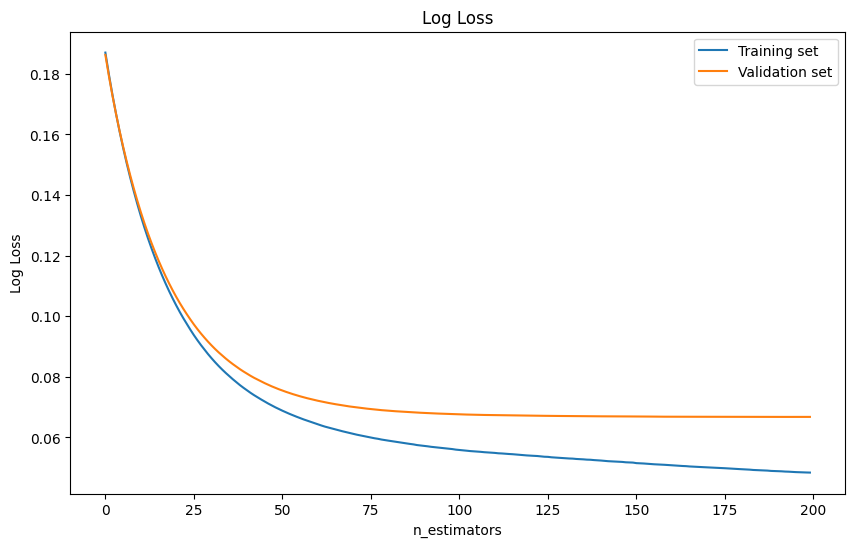

<Figure size 1000x600 with 0 Axes>

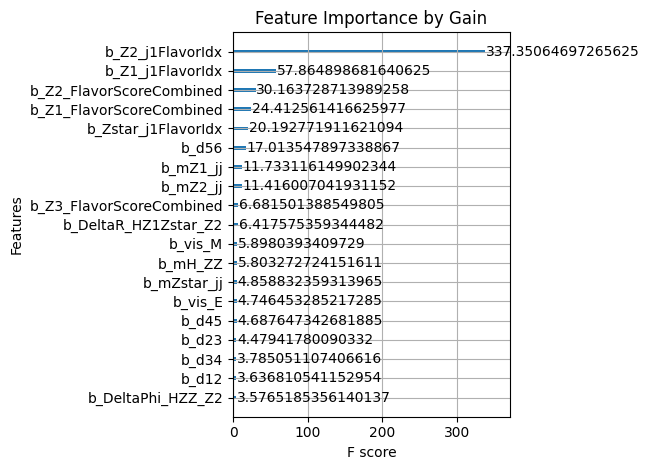

In [59]:
bdt.train_model()

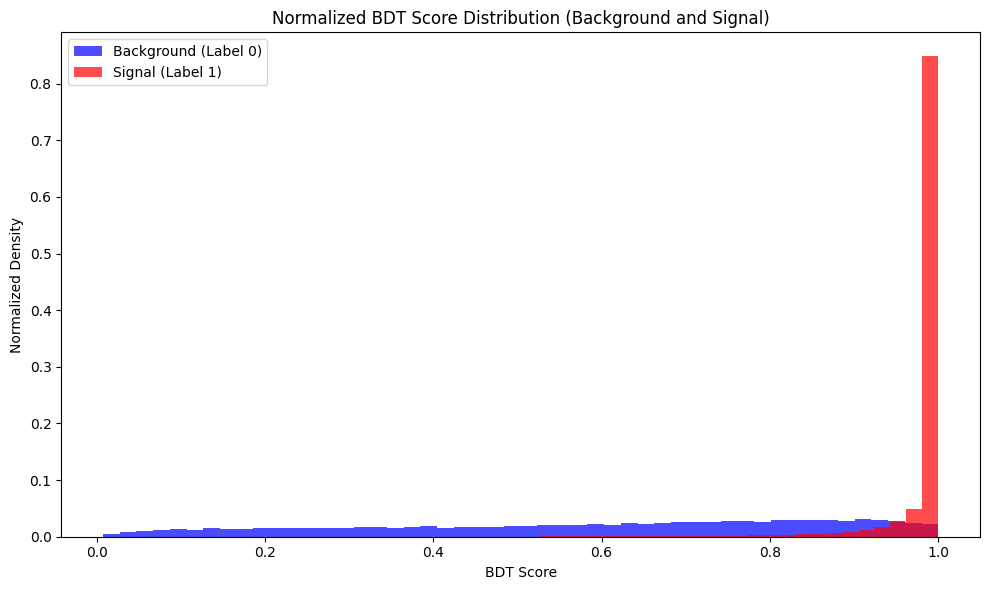

In [55]:
bdt.plot_bdt_score()

In [60]:
bdt.find_optimal_bdt_threshold()

Maximum S/sqrt(B) = 41444.60 at BDT score threshold = 0.99


np.float64(0.99)